### Libraries

In [1]:
# processing:
import os
import json
import operator
from typing import TypedDict, Annotated, Any, Dict


# graph:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from pydantic_core import CoreSchema
from pydantic import BaseModel, GetJsonSchemaHandler
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from tavily import TavilyClient # <- websearch
from duckduckgo_search import DDGS

In [2]:
from langchain_openai import ChatOpenAI

##### .env

In [3]:
from dotenv import load_dotenv

load_dotenv('.env', override=True)

openai_api = os.getenv("OPENAI_API_KEY")
openrouter = os.getenv("OPENROUTER_API_KEY")
gigachat_api = os.getenv("GIGACHAT_AUTH_DATA")
proxy_api = os.getenv("PROXY_API_KEY")

#### KST

In [4]:
path = 'ks_one.json'

with open(path, 'r') as file:
    kst_one = json.load(file)

In [5]:
labels = [node['label'] for node in kst_one['nodes']]

sorted_labels = sorted(labels)

for label in sorted_labels[:3]:
    print(label)

A.1.1 Definition of Machine Learning
A.1.2 Machine Learning vs. Traditional Programming
A.2.1 Understanding Datasets


#### Agent

##### Tools

In [6]:
@tool
def get_node_by_id(node_id: int):
    """
    Retrieve a node by its ID.
    """
    for node in kst_one['nodes']:
        if node['id'] == int(node_id):
            label = node['label']
            content = node['content']
            return label + ': ' + content
        
    raise KeyError(f"Node with ID {node_id} not found.")
    # return 1

@tool
def get_target_nodes(node_id):
    """
    Retrieve all target nodes that the given node points to (outgoing connections).
    """
    target_nodes = []
    for edge in kst_one['edges']:
        if edge['source'] == int(node_id):
            for connection in edge.get('connections', []):
                target_node = None
                for node in kst_one['nodes']:
                    if node['id'] == connection['target']:
                        target_node = node
                        break
                if target_node:
                    target_nodes.append(target_node)

    return target_nodes

In [7]:
tools = [get_node_by_id, get_target_nodes]

tool_node = ToolNode(tools)

In [8]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_node_by_id",
            "args": {"graph": kst_one, "node_id": 2},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='A.1.2 Machine Learning vs. Traditional Programming: In this module, we will explore the fundamental differences between Machine Learning (ML) and traditional programming. Traditional programming is a process where a programmer writes a set of explicit instructions for the computer to follow. These instructions are based on specific rules and logic that the programmer defines. For example, if you want a computer to calculate the sum of two numbers, you would write a program that tells the computer exactly how to perform that calculation step by step.\n\nOn the other hand, Machine Learning takes a different approach. Instead of relying on explicit instructions, ML involves training algorithms on large datasets. The algorithm learns patterns and relationships within the data, allowing it to make predictions or decisions based on new, unseen data. For instance, in image recognition, rather than programming the computer to identify specific features of an 

In [9]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_node_by_id",
            "args": {"node_id": 1},
            "id": "tool_call_id",
            "type": "tool_call",
        },
        {
            "name": "get_target_nodes",
            "args": {"node_id": 4},
            "id": "tool_call_id",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='A.1.1 Definition of Machine Learning: Machine Learning (ML) is a fascinating area of artificial intelligence that focuses on the development of algorithms that allow computers to learn from and make predictions based on data. Unlike traditional programming, where explicit instructions are given for every task, ML enables computers to identify patterns and make decisions autonomously by analyzing large datasets. \n\nAt its core, ML revolves around the idea of data-driven decision-making. This means that instead of relying solely on human input, machines can analyze historical data to uncover trends and insights that inform their predictions. For example, in healthcare, ML algorithms can analyze patient data to predict disease outbreaks or recommend personalized treatment plans. In finance, ML is used to detect fraudulent transactions by recognizing unusual patterns in spending behavior. Similarly, in e-commerce, ML helps personalize shopping experience

#### Tools with LLM

In [10]:
query = "what's graph's kst_one node 3?. Respond with: The number is: "

In [11]:
query = "Retrieve all target nodes for node 3?. Respond with explanation as if you are a Data Science Tutor. "

In [12]:
llm = ChatOpenAI(openai_api_key=proxy_api, model = "gpt-4o-mini", temperature=0.2, base_url = 'https://api.proxyapi.ru/openai/v1').bind_tools(tools)

In [13]:
llm.invoke(query)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HrKcpL0Cv4j6gutbn9rr8exq', 'function': {'arguments': '{"node_id":3}', 'name': 'get_target_nodes'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 100, 'total_tokens': 116, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-65d1cc65-3162-484a-9f20-d6d83d15f442-0', tool_calls=[{'name': 'get_target_nodes', 'args': {'node_id': 3}, 'id': 'call_HrKcpL0Cv4j6gutbn9rr8exq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 100, 'output_tokens': 16, 'total_tokens': 116})

In [14]:
tool_node.invoke({"messages": [llm.invoke(query)]})

{'messages': [ToolMessage(content='[{"id": 4, "label": "A.2.2 Features and Labels", "description": "This module focuses on features (independent variables) and labels (dependent variables) in the context of supervised ML tasks. It will explain how features are attributes used by a model to make predictions, while labels are the outcomes the model is trying to predict. Detailed examples from multiple domains, such as customer segmentation and predictive maintenance, will demonstrate how to distinguish between features and labels. The module will also touch on how to properly select and preprocess features for effective model training.", "content": "In supervised machine learning (ML), understanding the concepts of features and labels is crucial for building effective models. \\n\\n**Features** are the individual measurable properties or characteristics of the data that are used by the model to make predictions. They are often referred to as independent variables because they can influen

#### Agent

In [15]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

In [16]:
memory = SqliteSaver.from_conn_string(":memory:")

In [17]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

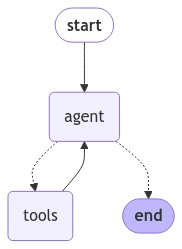

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
for chunk in app.stream(
    {"messages": [("human", query)]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Retrieve all target nodes for node 3?. Respond with explanation as if you are a Data Science Tutor. 
================================== Ai Message ==================================
Tool Calls:
  get_target_nodes (call_34HildHPuGHpIe6VJazm8uXi)
 Call ID: call_34HildHPuGHpIe6VJazm8uXi
  Args:
    node_id: 3
================================= Tool Message =================================
Name: get_target_nodes

[{"id": 4, "label": "A.2.2 Features and Labels", "description": "This module focuses on features (independent variables) and labels (dependent variables) in the context of supervised ML tasks. It will explain how features are attributes used by a model to make predictions, while labels are the outcomes the model is trying to predict. Detailed examples from multiple domains, such as customer segmentation and predictive maintenance, will demonstrate how to distinguish between features and labels. The m

In [20]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [21]:
@tool
def get_node_by_id(node_id: int):
    """
    Retrieve a node by its ID.
    """
    for node in kst_one['nodes']:
        if node['id'] == int(node_id):
            label = node['label']
            content = node['content']
            return label + ': ' + content
        
    raise KeyError(f"Node with ID {node_id} not found.")
    # return 1

@tool
def get_target_nodes(node_id):
    """
    Retrieve all target nodes that the given node points to (outgoing connections).
    """
    target_nodes = []
    for edge in kst_one['edges']:
        if edge['source'] == int(node_id):
            for connection in edge.get('connections', []):
                target_node = None
                for node in kst_one['nodes']:
                    if node['id'] == connection['target']:
                        target_node = node
                        break
                if target_node:
                    target_nodes.append(target_node)

    return target_nodes



class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}
    
prompt = """You are a smart KST graph query specialist \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o-mini")
 
abot = Agent(model, [tool], system = prompt, checkpointer = MemorySaver())

AttributeError: 'function' object has no attribute 'name'

In [22]:
@tool
def get_node_by_id(node_id: int):
    """
    Retrieve a node by its ID.
    """
    for node in kst_one['nodes']:
        if node['id'] == int(node_id):
            label = node['label']
            content = node['content']
            return label + ': ' + content
        
    raise KeyError(f"Node with ID {node_id} not found.")

@tool
def get_target_nodes(node_id: int):
    """
    Retrieve all target nodes that the given node points to (outgoing connections).
    """
    target_nodes = []
    for edge in kst_one['edges']:
        if edge['source'] == int(node_id):
            for connection in edge.get('connections', []):
                target_node = None
                for node in kst_one['nodes']:
                    if node['id'] == connection['target']:
                        target_node = node
                        break
                if target_node:
                    target_nodes.append(target_node)

    return target_nodes

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

prompt = """You are a smart KST graph query specialist \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(llm, [get_node_by_id, get_target_nodes], system=prompt, checkpointer=MemorySaver())

In [23]:
messages = [HumanMessage(content="what's graph's kst_one node 3?. Respond with: The number is: ")]

In [24]:
thread = {"configurable": {"thread_id": "1"}}

In [25]:
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8WfmH9nV0xdZkRtjnabVoUvd', 'function': {'arguments': '{"node_id":3}', 'name': 'get_node_by_id'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 155, 'total_tokens': 172, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9cbeff87-b526-4670-b840-8eefd922d5ee-0', tool_calls=[{'name': 'get_node_by_id', 'args': {'node_id': 3}, 'id': 'call_8WfmH9nV0xdZkRtjnabVoUvd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 155, 'output_tokens': 17, 'total_tokens': 172})]
Calling: {'name': 'get_node_by_id', 'args': {'node_id': 3}, 'id': 'call_8WfmH9nV0xdZkRtjnabVoUvd', 'type': 'tool_call'}
Back to the model!
[ToolMessage(content='A.2.1 Understanding Datasets: In the realm of Machine Learning (ML), a dataset serves as the cornerstone fo

In [65]:
messages = [HumanMessage(content="Which node is next?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fByJatCw4h7EPwjebVe1a3N0', 'function': {'arguments': '{"node_id":5}', 'name': 'get_target_nodes'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 3446, 'total_tokens': 3462, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a109d43e-0566-4868-a359-26279feba0dd-0', tool_calls=[{'name': 'get_target_nodes', 'args': {'node_id': 5}, 'id': 'call_fByJatCw4h7EPwjebVe1a3N0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3446, 'output_tokens': 16, 'total_tokens': 3462})]}
Calling: {'name': 'get_target_nodes', 'args': {'node_id': 5}, 'id': 'call_fByJatCw4h7EPwjebVe1a3N0', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'id\': 6, \'label\': \'A.3.2 Understanding Algorithms\', \'descript

In [71]:
abot.graph.get_state

<bound method Pregel.get_state of CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x110104630>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']), ChannelWrite<start:llm>(recurse=True, writes=[ChannelWriteEntry(channel='start:llm', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'llm': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'messages': 'messages'}, triggers=['action', 'start:llm'], mapper=functools.partial(<function _coerce_state at 0x110661120>, <class '__main__.AgentState'>), writers=[ChannelWrite<llm,messages>(recurse=True, writes=[ChannelWriteEntry(channel='llm', value='llm', skip_none=False, mapper=None), ChannelWriteEntry(cha

In [27]:
messages = [HumanMessage(content = "Teach me about dasasets")]
thread = {"configurable": {"thread_id": "4"}}

async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

Datas|ets| are| fundamental| components| in| the| field| of| data| science| and| machine| learning|.| They| serve| as| the| foundation| for| developing| predictive| models| and| conducting| analyses|.| Here's| an| overview| of| what| datasets| are|,| their| types|,| and| their| importance|:

|###| What| is| a| Dataset|?
|A| dataset| is| a| collection| of| data| organized| in| a| structured| format|,| typically| consisting| of| rows| and| columns|.| Each| row| represents| a| single| observation| or| data| point|,| while| each| column| corresponds| to| a| specific| feature| or| attribute| of| that| observation|.

|###| Types| of| D|atasets|

|1|.| **|Tab|ular| Data|**|:
|  | -| This| is| the| most| common| format|,| where| data| is| organized| in| tables|.
|  | -| Each| column| contains| a| specific| type| of| information|,| such| as| numerical| values| or| categorical| labels|.
|  | -| Example|:| A| dataset| of| customer| information| might| include| columns| for| age|,| gender|,| and| 